In [1]:
from omegaconf import OmegaConf
import numpy as np
import os
import re
import os.path as osp
import torch
import pandas as pd
import pickle

from transform_factory import factory as transforms
import model_factory
from graph_data_module import GraphDataModule
from train import Runner
from datasets_torch_geometric.dataset_factory import create_dataset
from torch_geometric.loader import DataLoader
from utils.config_utils import get_checkpoint_file, get_config_file, show_cfg
import matplotlib.pyplot as plt

In [2]:
losses_dict = {}
vec_sum_dict = {}
norm_mean_dict = {}
cosine_sim_dict = {}


vec_sum_df = {}
norm_mean_df = {}
cosine_sim_df = {}

In [3]:
def cosine_similarity(matrix_list):
    if isinstance(matrix_list, np.ndarray):
        matrix_list = [matrix_list]
    # Calculate the dot product of the matrix with its transpose
    for matrix in matrix_list[1:]:
        assert matrix.shape[1] == matrix_list[0].shape[1], "All matrices must have the same number of columns"
        
    dot_product = np.zeros((matrix_list[0].shape[1], matrix_list[0].shape[1]))
    for matrix in matrix_list:
        dot_product += np.dot(matrix.T, matrix)

    # Compute the norms of the columns
    norms = np.zeros((matrix_list[0].shape[1]))
    for matrix in matrix_list:
        norms += np.sum(matrix**2, axis=0)
    norms = np.sqrt(norms)
    
    # Compute the outer product of norms to obtain the denominator for cosine similarity
    denominator = np.outer(norms, norms)
    print(denominator.shape)
    print(denominator.reshape(-1).min())
    # Avoid division by zero by replacing zero values with a small epsilon
    denominator[denominator == 0] = np.finfo(float).eps
    
    # Compute cosine similarity matrix
    cosine_sim = dot_product / denominator
    np.fill_diagonal(cosine_sim, 0)
    return cosine_sim



In [4]:
experiment = "non-trained"
# experiment = "fully trained"
# experiment = "5 epoch trained"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if experiment == "non-trained":
    sparse_path = "haraghi/sweep EST (FAN1VS3) (multi val test num 20)/bnq6i70m"
    dense_path = "haraghi/sweep EST (FAN1VS3) 25000 (multi val test num 20)/no47hfm9"
    cfg_sparse,_ = get_config_file(*sparse_path.split("/"))
    cfg_dense,_ = get_config_file(*dense_path.split("/"))

    model_sparse = model_factory.factory(cfg_sparse)
    runner_sparse = Runner(cfg=cfg_sparse, model=model_sparse).to(device)
    runner_dense = Runner(cfg=cfg_dense, model=model_sparse).to(device)
else:
    if experiment == "fully trained":
        sparse_path = "haraghi/sweep EST (FAN1VS3) (multi val test num 20)/bnq6i70m"
        dense_path = "haraghi/sweep EST (FAN1VS3) 25000 (multi val test num 20)/no47hfm9"
    elif experiment == "5 epoch trained":
        sparse_path = "haraghi/DGCNN/x0x9h3ux"
        dense_path = "haraghi/DGCNN/yq3e10ls"
    else:
        raise ValueError(f"Unknown experiment: {experiment}")

    checkpoint_file_sparse = get_checkpoint_file(*sparse_path.split("/"))
    checkpoint_file_dense = get_checkpoint_file(*dense_path.split("/"))
    cfg_sparse,_ = get_config_file(*sparse_path.split("/"))
    cfg_dense,_ = get_config_file(*dense_path.split("/"))
    model_sparse = model_factory.factory(cfg_sparse)
    model_dense = model_factory.factory(cfg_dense)
    runner_dense = Runner.load_from_checkpoint(checkpoint_path=checkpoint_file_dense, cfg=cfg_sparse, model=model_dense).to(device)
    runner_sparse = Runner.load_from_checkpoint(checkpoint_path=checkpoint_file_sparse, cfg=cfg_sparse, model=model_sparse).to(device)
    
    
assert cfg_dense.transform.train.transform, "The dense model must have transform enabled"
assert cfg_dense.transform.train.num_events_per_sample == 25000, "The dense model must have num_events_per_sample=25000"
assert not cfg_dense.pre_transform.train.num_events_per_sample, "The dense model must have num_events_per_sample disabled"
assert not cfg_dense.pre_transform.train.transform, "The dense model must have transform disabled" 

cfg_folder/EST_FAN1VS3_1024_wandb_sweep.yaml
cfg_file
--------------------------------------------------
optimize:
  patience: 10
seed: 0
train:
  batch_size: 8
wandb:
  entity: ''
  project: ''

cfg
--------------------------------------------------
cfg_path: cfg_folder/EST_FAN1VS3_1024_wandb_sweep.yaml
dataset:
  num_classes: 2
optimize:
  patience: 40
seed: 7
train:
  batch_size: 32
wandb:
  entity: haraghi
  project: DGCNN

cfg_folder/EST_FAN1VS3_25000_wandb_sweep.yaml
cfg_file
--------------------------------------------------
optimize:
  lr: 0.0001
seed: 0
train:
  batch_size: 8
  epochs: 100

cfg
--------------------------------------------------
cfg_path: cfg_folder/EST_FAN1VS3_25000_wandb_sweep.yaml
dataset:
  num_classes: 2
optimize:
  lr: 0.01
seed: 1
train:
  batch_size: 16
  epochs: 250



In [5]:
datasets_path = 'datasets_torch_geometric'
sparse_dataset =   create_dataset(
                dataset_path = os.path.join(datasets_path, cfg_sparse.dataset.name, 'data'),
                dataset_name  = cfg_sparse.dataset.name,
                dataset_type = 'training',
                transform = transforms(cfg_sparse.transform.train),
                pre_transform=transforms(cfg_sparse.pre_transform.train),
                num_workers=3
            )
dense_dataset =   create_dataset(
                dataset_path = os.path.join(datasets_path, cfg_dense.dataset.name, 'data'),
                dataset_name  = cfg_dense.dataset.name,
                dataset_type = 'training',
                transform = transforms(cfg_dense.transform.train),
                pre_transform=transforms(cfg_dense.pre_transform.train),
                num_workers=3
            )

cfg_sparse.dataset.num_classes = sparse_dataset.num_classes
cfg_dense.dataset.num_classes = dense_dataset.num_classes

In [6]:
a = []
for i in range(10):
    a.append(dense_dataset[0].pos[:2,0])
    
print(np.array(a))

[[415. 672.]
 [333. 351.]
 [628. 555.]
 [671. 552.]
 [728. 487.]
 [592. 313.]
 [338. 520.]
 [539. 375.]
 [439. 848.]
 [937. 392.]]


In [7]:
# idx_list = [np.random.randint(len(dense_dataset))]
idx_list = [181]
results_dict = {}
for case in ['sparse', 'dense']:
    runner = runner_sparse if case == 'sparse' else runner_dense
    grads = {}
    ws = {}
    losses = []
    for idx in idx_list:
        for i in range(100):
            runner.model.zero_grad()
            data = eval(case + '_dataset')[idx]
            # if case == 'dense':  
            #     num_nodes = data.num_nodes
            #     perm = torch.randperm(num_nodes, requires_grad=False)
            #     data.pos = data.pos[perm,:]
            #     data.x = data.x[perm,:] 
            #     data.pos = data.pos[1000:,:]
            #     data.x = data.x[1000:,:]
            
            data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
            data = data.to(device)
            loss, out = runner._step(data)
            losses.append(loss.item())
            loss.backward()

            if i == 0:
                ws['conv1'] = []
            ws['conv1'].append(runner.model.classifier.conv1.weight.data.clone().detach().cpu().view(-1,1).numpy())
            if i > 0:
                assert np.allclose(ws['conv1'][-1], ws['conv1'][-2]), 'conv1 changed'
            for l in range(1,5):
                for name, param in getattr(runner.model.classifier, f'layer{l}')[-1].named_parameters():
                    if 'conv2' in name:
                        if i == 0:
                            ws[f'layer{l}_conv2'] = []
                        ws[f'layer{l}_conv2'].append(param.data.clone().detach().cpu().view(-1,1).numpy())
                        if i > 0:
                            assert np.allclose(ws[f'layer{l}_conv2'][-1], ws[f'layer{l}_conv2'][-2]), f'layer{l}_conv2 changed'
            if i == 0:
                grads['conv1'] = []
            grads['conv1'].append(runner.model.classifier.conv1.weight.grad.clone().detach().cpu().view(-1,1).numpy())
            for l in range(1,5):
                for name, param in getattr(runner.model.classifier, f'layer{l}')[-1].named_parameters():
                    if 'conv2' in name:
                        if i == 0:
                            grads[f'layer{l}_conv2'] = []
                        grads[f'layer{l}_conv2'].append(param.grad.clone().detach().cpu().view(-1,1).numpy())

    for k in grads.keys():
        grads[k] = np.concatenate(grads[k], axis=1)
    # for k in ws.keys():
    #     ws[k] = np.concatenate(ws[k], axis=1)
    results_dict[case] = {}
    results_dict[case]['grads'] = grads
    # results_dict[case]['ws'] = ws
    results_dict[case]['losses'] = np.array(losses)

losses_dict[experiment] = {}
vec_sum_dict[experiment] = {}
norm_mean_dict[experiment] = {}
cosine_sim_dict[experiment] = {}

for case in ['sparse', 'dense']:
    print(f'Case: {case}')
    grads_vec = results_dict[case]['grads']
    losses_dict[experiment][case] = results_dict[case]['losses']
    vec_sum_dict[experiment][case] = []
    cosine_sim_dict[experiment][case] = []
    norm_mean_dict[experiment][case] = []
    # Calculate the cosine similarity matrix
    for k,v in grads_vec.items():
        print(f'Layer: {k}')
        cosine_sim_dict[experiment][case].append(cosine_similarity(v))
        vec_sum_dict[experiment][case].append(np.linalg.norm(np.sum(v, axis=1)))
        norm_mean_dict[experiment][case].append(np.mean(np.linalg.norm(v, axis=0)))
for case in ['sparse', 'dense']:
    print(f'Case: {case}')
    grads_vec = results_dict[case]['grads']
    all_sum = []
    all_pow_2 = []
    for k,v in grads_vec.items():
        all_sum.append(np.sum(v, axis=1))
        all_pow_2.append(np.sum(v**2, axis=0))
    all_sum = np.concatenate(all_sum, axis=0)
    all_pow_2 = np.sum(all_pow_2, axis=0)
    # print(all_pow_2.shape)
    vec_sum_dict[experiment][case].append(np.linalg.norm(all_sum))
    norm_mean_dict[experiment][case].append(np.mean(np.sqrt(all_pow_2)))
    cosine_sim_dict[experiment][case].append(cosine_similarity(list(grads_vec.values())))
vec_sum_df[experiment] = pd.DataFrame(vec_sum_dict[experiment], index=[*results_dict['sparse']['grads'].keys(), 'all'])
norm_mean_df[experiment] = pd.DataFrame(norm_mean_dict[experiment], index=[*results_dict['sparse']['grads'].keys(), 'all']) 
cosine_sim_df[experiment] = pd.DataFrame(cosine_sim_dict[experiment], index=[*results_dict['sparse']['grads'].keys(), 'all'])    

KeyboardInterrupt: 

In [ ]:
vec_sum_df

In [ ]:
folder_dir = os.path.join('images', 'paper', 'grad_diversity')
with open(os.path.join(folder_dir, 'grad_diversity_results.pkl'), 'wb') as f:
    pickle.dump((vec_sum_df, norm_mean_df, cosine_sim_df), f)

In [8]:
folder_dir = os.path.join('images', 'paper', 'grad_diversity')
with open(os.path.join(folder_dir, 'grad_diversity_results.pkl'), 'rb') as f:
    vec_sum_df, norm_mean_df, cosine_sim_df = pickle.load(f)

In [9]:
layer_names_dict = {}
for layer in vec_sum_df[list(vec_sum_df.keys())[0]].index[:-1]:
    if 'conv1' in layer:
        layer_names_dict[layer] = 'conv1'
    elif 'layer1' in layer:
        layer_names_dict[layer] = 'layer1.2.conv2'
    elif 'layer2' in layer:
        layer_names_dict[layer] = 'layer2.3.conv2'
    elif 'layer3' in layer:
        layer_names_dict[layer] = 'layer3.5.conv2'
    elif 'layer4' in layer:
        layer_names_dict[layer] = 'layer4.2.conv2'
    else:
        raise ValueError(f'Unknown layer: {layer}')

In [ ]:
layer_names_dict

fully trained


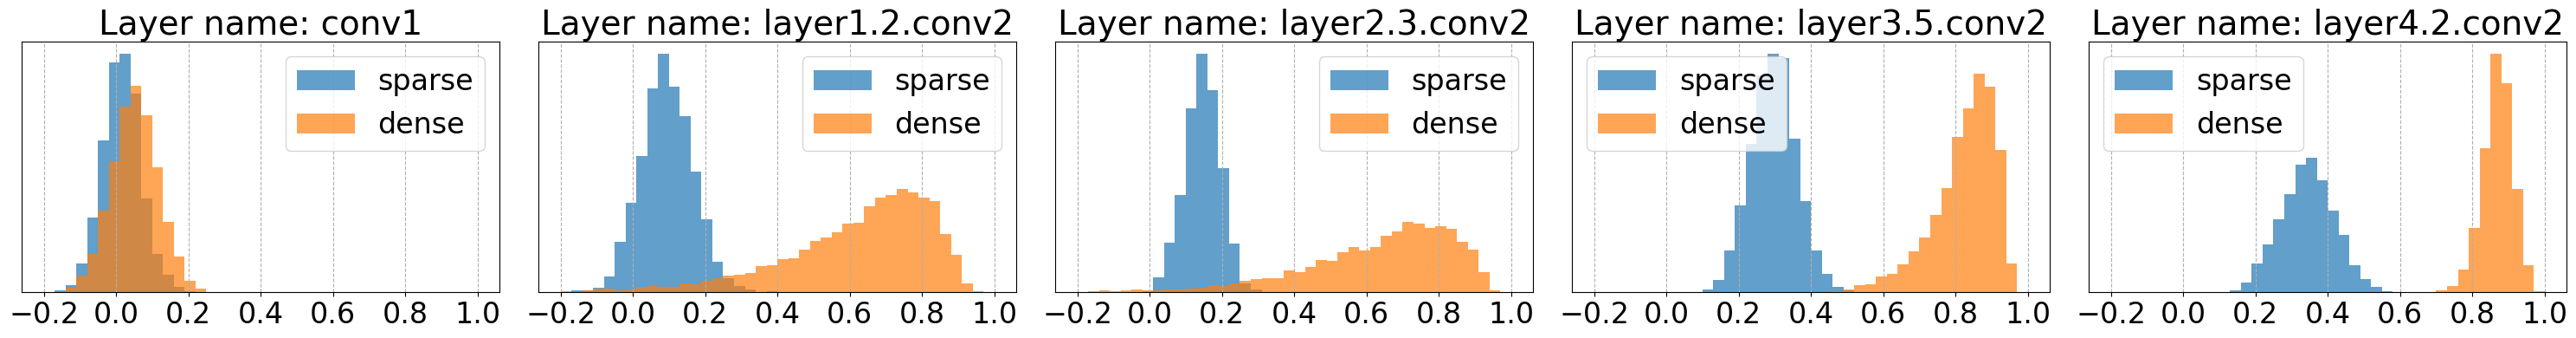

5 epoch trained


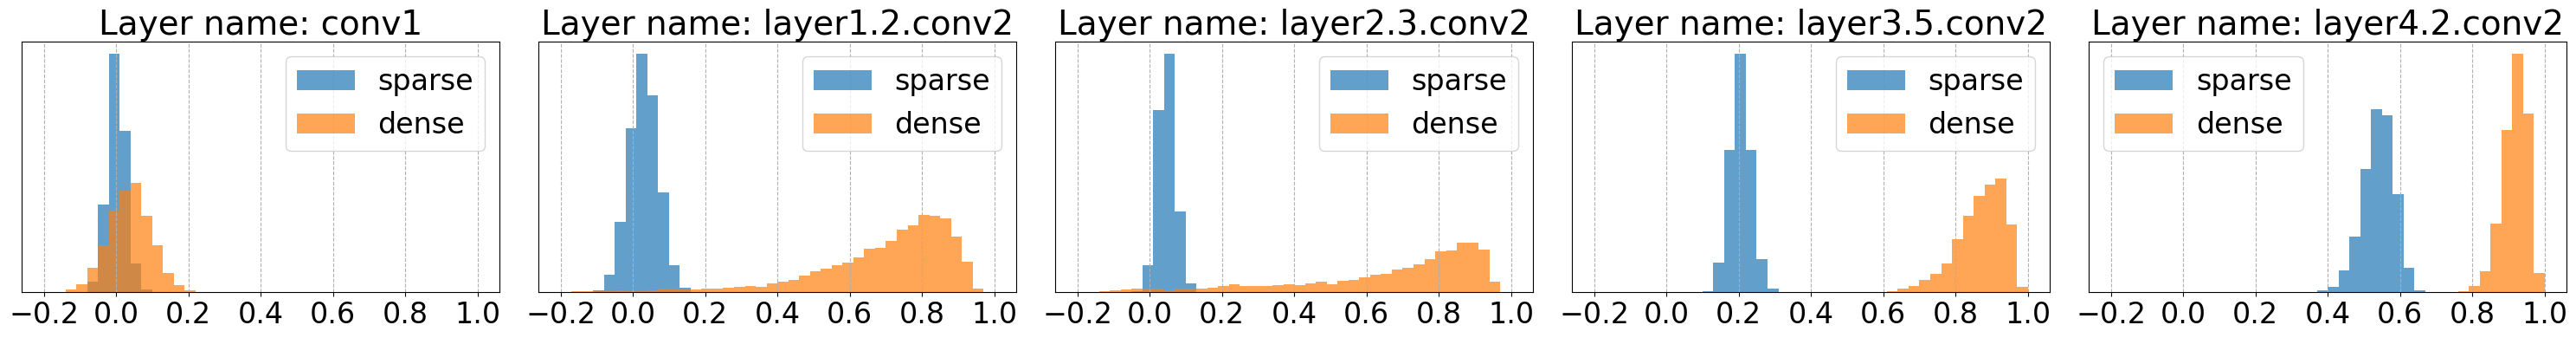

non-trained


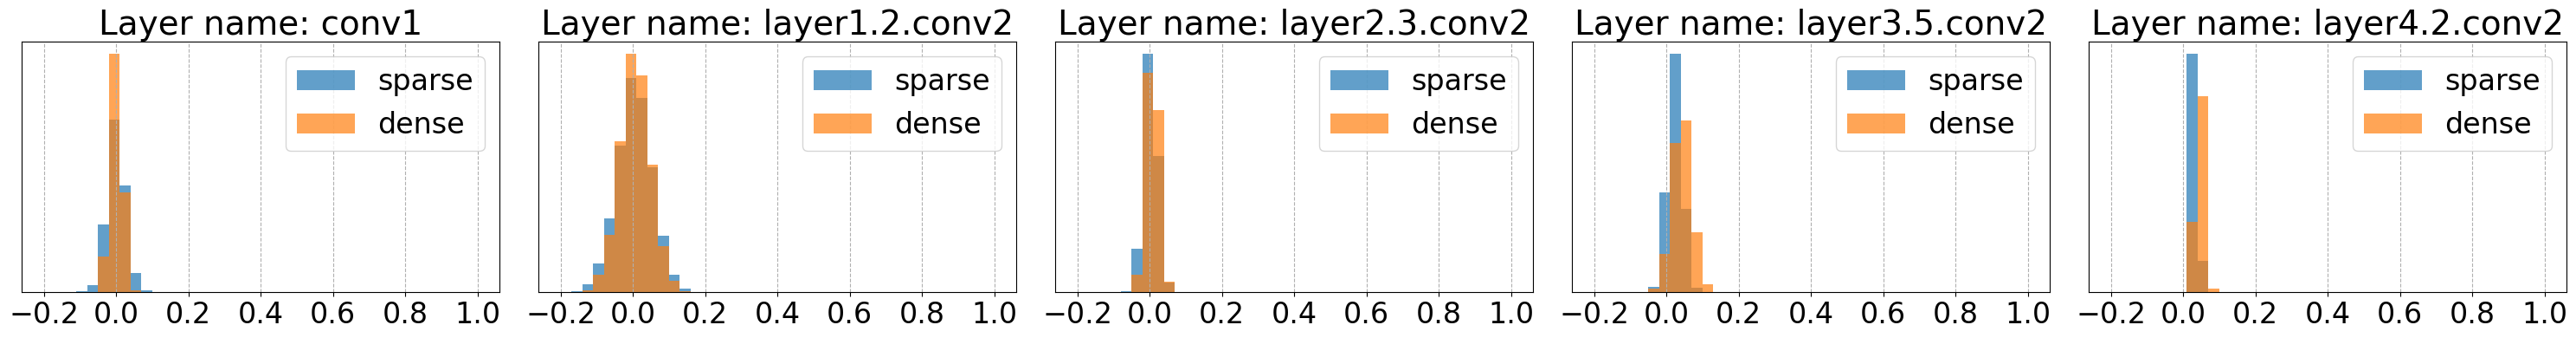

In [11]:
cases = ['sparse', 'dense']
for exper, cos_sim in cosine_sim_df.items():
    print(exper)
    fig, axs = plt.subplots(1, 5, figsize=(30, 4))
    axis_idx = 0
    for layer in cos_sim.index[:-1]:

        upper_triangle_list = []
        
        for case in cases:
            # Plot the first image 
            upper_triangle = np.triu(cos_sim[case][layer])
            upper_triangle_list.append(upper_triangle[np.nonzero(upper_triangle)])
            axs[axis_idx].hist(upper_triangle[np.nonzero(upper_triangle)], bins=40, alpha=0.7, label=case, range=(-0.2,1) ,edgecolor='none', density=True ) 
        # axs[axis_idx].set_xlabel(f"Histogram of Upper Triangle Cosine Similarity", fontsize=14)
        # axs[axis_idx].set_ylabel('Frequency', fontsize=14)
        
        axs[axis_idx].set_yticks([])  # Remove x-axis ticks
        axs[axis_idx].set_xticks([-.2,0,0.2,0.4,0.6,0.8,1.0])  # Remove x-axis ticks
        axs[axis_idx].tick_params(axis='both', labelsize=24)  # Set tick label font size      
        axs[axis_idx].grid(axis='x', linestyle='--')  # Add pale and dashed grid lines along the x-axis
        axs[axis_idx].legend(fontsize=24)
        axs[axis_idx].set_title(f"Layer name: {layer_names_dict[layer]}", fontsize=28) # number of parameters: {results_dict[case]['grads'][layer].shape[0]}")
        axis_idx += 1

        # Adjust the spacing between subplots
    # fig.suptitle(f"For {exper} models")
    plt.tight_layout()
    plt.savefig(osp.join(folder_dir,f"Histogram_cosine_similarity_per_layer_{exper}.svg"), format = 'svg', dpi=300)  
    # Show the plot
    plt.show()
